In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = np.loadtxt('samsung_train.txt')
y_train = np.loadtxt('samsung_train_labels.txt')
X_test = np.loadtxt('samsung_test.txt')
y_test = np.loadtxt('samsung_test_labels.txt')

In [3]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((7352, 561), (2947, 561), (7352,), (2947,))

In [4]:
X = np.vstack([X_train,X_test])
y = np.hstack([y_train,y_test])
X.shape , y.shape

((10299, 561), (10299,))

In [5]:
n_classes = np.unique(y).shape[0]
n_classes

6

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
%%time
pca = PCA(n_components=0.9,random_state=17)
X_pca = pca.fit_transform(X_scaled)

Wall time: 1.22 s


In [8]:
pca.n_components_ , pca.explained_variance_ratio_[0]*100

(65, 50.73822103501339)

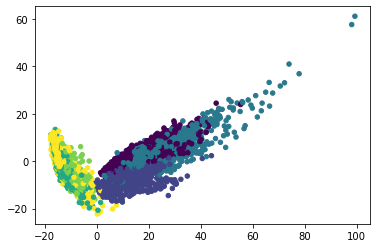

In [9]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,s=20,cmap='viridis');

In [10]:
%%time
kmeans = KMeans(n_clusters=n_classes,n_init=100,random_state=17)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Wall time: 9.12 s


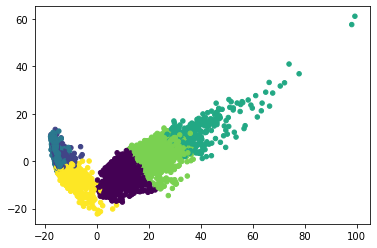

In [11]:
plt.scatter(X_pca[:,0],X_pca[:,1],c=cluster_labels,s=20,cmap='viridis');

In [12]:
tab = pd.crosstab(y,cluster_labels,margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster'+str(i+1) for i in range(6)]+['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


In [13]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1).values/tab.iloc[:-1,-1].values , index=tab.index[:-1]).sort_values(ascending=False)

подъем вверх по лестнице    0.803756
лежание                     0.801440
стояние                     0.705142
сидение                     0.694992
спуск по лестнице           0.633001
ходьба                      0.524390
dtype: float64

In [14]:
inertia = []
for k in tqdm_notebook(range(1,n_classes+1)):
    kmeans = KMeans(n_clusters=k,n_init=100,random_state=17,n_jobs=-1).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))
    

  0%|          | 0/6 [00:00<?, ?it/s]

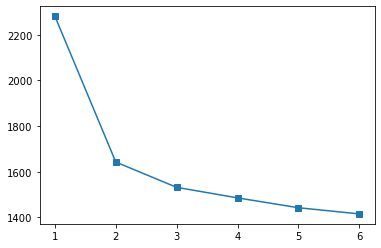

In [15]:
plt.plot(range(1,7),inertia,marker='s');

In [16]:
%%time
ag =AgglomerativeClustering(n_clusters=n_classes,linkage='ward').fit(X_pca)
metrics.adjusted_rand_score(y,ag.labels_)

Wall time: 8.95 s


0.49362763373004886

In [17]:
metrics.adjusted_rand_score(y,kmeans.labels_)

0.4198070012602345

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
%%time
svc = LinearSVC(random_state=17)
params = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}
grid_search_cv_svc = GridSearchCV(estimator=svc,param_grid=params,n_jobs=-1,cv=3).fit(X_train_scaled,y_train)
grid_search_cv_svc.best_estimator_ , grid_search_cv_svc.best_score_

Wall time: 40.7 s


(LinearSVC(C=0.1, random_state=17), 0.9382506099134881)

In [20]:
grid_search_cv_svc.best_estimator_ , grid_search_cv_svc.best_score_

(LinearSVC(C=0.1, random_state=17), 0.9382506099134881)

In [21]:
pca = PCA(n_components=0.9,random_state=17)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [22]:
%%time
svc = LinearSVC(random_state=17)
params = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}
grid_search_cv_svc_pca = GridSearchCV(estimator=svc,param_grid=params,n_jobs=-1,cv=3).fit(X_train_scaled_pca,y_train)
grid_search_cv_svc_pca.best_estimator_ , grid_search_cv_svc_pca.best_score_

Wall time: 11.1 s


(LinearSVC(C=1, random_state=17), 0.8998943094169531)